# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

In [208]:
# JPG output path
jpg_outdir = '/glade/scratch/dkorytin/taylor_jpgs/'

In [3]:
# Ordering: nRow ordering: obs, raw, RegCM4, WRF, MPAS, CNN, SDSM, KDDM, MBCn, LOCA
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2099.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

# Compact Configuration

In [4]:
sigdir = '/glade/work/mcginnis/DCA/data/gen/final'
def model2absfilepath(mn, exp, x, y):
    if mn == 'obs' or mn == 'gridMET':
        mn = 'gridMET'
        filename = 'prec.{}.gridMET.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'obs', x, y)
    elif mn == 'raw' or mn == 'mpi':
        mn = 'mpi'
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        else: print("Unknown experiment!")
    elif mn == 'SDSM':  # starts at 1976
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1976-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2070-2099.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        else: print("Unknown experiment!")

    elif exp == 'hist':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    elif exp == 'rcp85':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    else: print("Unknown experiment!")
    return sigdir + '/' + mn.lower() + '/' + exp + '/' + filename
    

In [5]:
# test single file
model2absfilepath('RegCM4', 'rcp85', 98, 36)

'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc'

In [6]:
# create list of abs filepaths
[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hi

### Load model output data

In [7]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [8]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [9]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80)) * 1000 # convert to g/kg
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80)) * 1000 # convert to g/kg
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [10]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal, month, ymin, ymax):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    mnvars = 8
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == month and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    



            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices


def calc_prec_average(mpr_min, mpr_max, rainsignal, month, ymin, ymax):
    
    # initialize accumulators
    indices = []
    distribution = []
    raininput = 0
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == month and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    

            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                raininput += mpr
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Stat routines

In [11]:
from os.path import basename
from scipy.stats import spearmanr

def linear_regression(x, y): 
    coefs = np.polynomial.polynomial.polyfit(x, y, 1)
    ffit = np.poly1d(coefs)
    m = ffit[0]
    b = ffit[1] 
    eq = 'y = {}x + {}'.format(round(m, 3), round(b, 3))
    pc = np.corrcoef(x, y)[0, 1]
                  
    return pc, eq, m, b



def plot_scatter(X, Y, title):     

    print ("model:", title)


    # plot best fit line
    pc, eq, m, b = linear_regression(X,Y)
    xmaxreg = max(X)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(Y): 
        xmaxreg = (max(Y)-b) / m
    plt.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    #rowtitle = '.'.join(sigfilename.split('.')[0:4])
    rowtitle = title
    #plt.scatter(X, Y, color="tab:blue", s=1, label='prec (mm/day)')
    plt.scatter(X, Y, color="tab:blue", label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(X,Y)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((np.array(X)-np.array(Y))**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    plt.legend(loc="lower right", title=r2_text)
    
    # draw 1:1 line
    X = np.linspace(0, .03, num=50) 
    plt.plot(X, X, 'x')


#     # title
#     sigfilename = basename(sigfile)
#     title = sigfilename.split('.')[5] + ' ' + '.'.join(sigfilename.split('.')[7:10])
#     plt.title( title.upper()+' vs. obs' )
    plt.title( title )
                
    plt.show()
    

# Run over all models

In [12]:
# # raw baselines (to be compared against)
# hist_baseline = []
# rcp85_baseline = []
# baseline = []         # change from hist to rcp85

# # use raw as baseline
# names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
# sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
# sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
# sigfn1 = sigfiles_hist[0]
# sigfn2 = sigfiles_rcp85[0]
# rainsignal1 = xr.open_dataset(sigfn1)['prec']
# rainsignal2 = xr.open_dataset(sigfn2)['prec']


# load_uatm_mpi_hist()
# for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
#     #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
#     baseline_avg_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
#     hist_baseline.append(baseline_avg_hist)
    
# load_uatm_mpi_future()
# for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
#     baseline_avg_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
#     rcp85_baseline.append(baseline_avg_rcp85)
    
# for ii in range(4):
#     baseline.append(rcp85_baseline[ii] - hist_baseline[ii])

# Future-hist (change signal)

In [587]:
# Calculate parameters for Taylor plots: dry/moist/wet

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# interate over models
XX=[]; YY=[]; ZZ=[]
allYY = []
for mii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[mii]
    sigfn2 = sigfiles_rcp85[mii]

    rainsignal1 = xr.open_dataset(sigfn1)['prec']
    rainsignal2 = xr.open_dataset(sigfn2)['prec']

    X=[]
    load_uatm_mpi_hist()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
        #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
        X.append(avginput_hist)
    allXX.append(X)
    
    Y=[]
    load_uatm_mpi_future()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
        Y.append(avginput_rcp85)
    
    # append diff
    allYY.append(np.array(Y) - np.array(X))
        
        
    # baseline: raw
    if mii == 0:
        baseline_hist = np.array(X)
        baseline_rcp85 = np.array(Y)
 
        
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for ii in range(4):
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            
            diff = np.array(Y[ii][vii]) - np.array(X[ii][vii])
            diffbaseline = np.array(baseline_rcp85[ii][vii]) - np.array(baseline_hist[ii][vii])
            
            sd = np.std(diff)
            cr = ((diff-diffbaseline)**2).mean()**0.5
            sc, delme = spearmanr(diffbaseline.flatten(),diff.flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            #print(mii, vii, float(sd), float(cr), float(sc))
            
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)

    XX.append(sd83)
    YY.append(cr83)
    ZZ.append(sc83)


In [583]:
np.array(XX).shape

(8, 8, 4)

In [584]:
np.array(XX)[:,0,2]

array([0.66873964, 0.58377739, 0.67149233, 0.62127885, 0.71727483,
       0.71192041, 0.73697289, 0.67525896])

<Figure size 432x288 with 0 Axes>

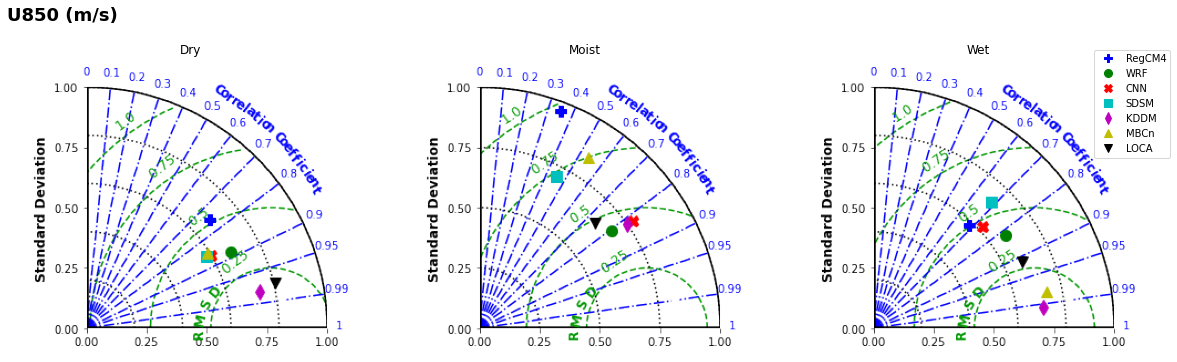

<Figure size 432x288 with 0 Axes>

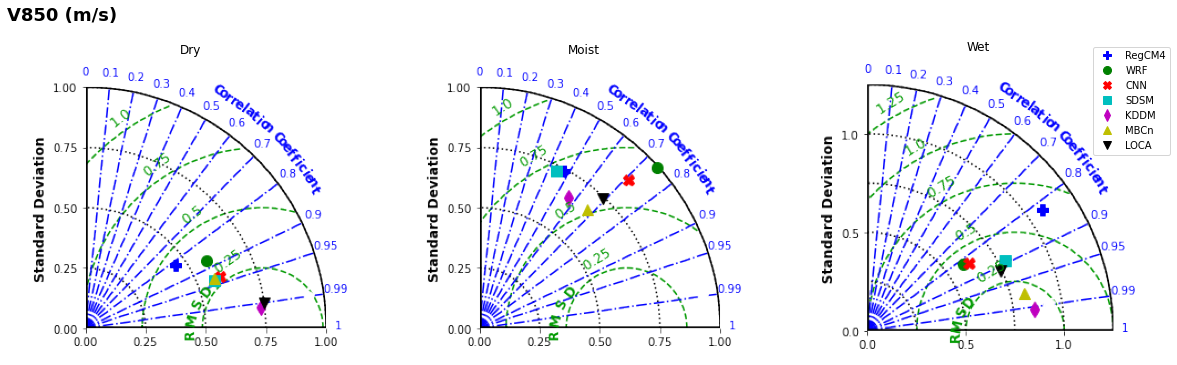

<Figure size 432x288 with 0 Axes>

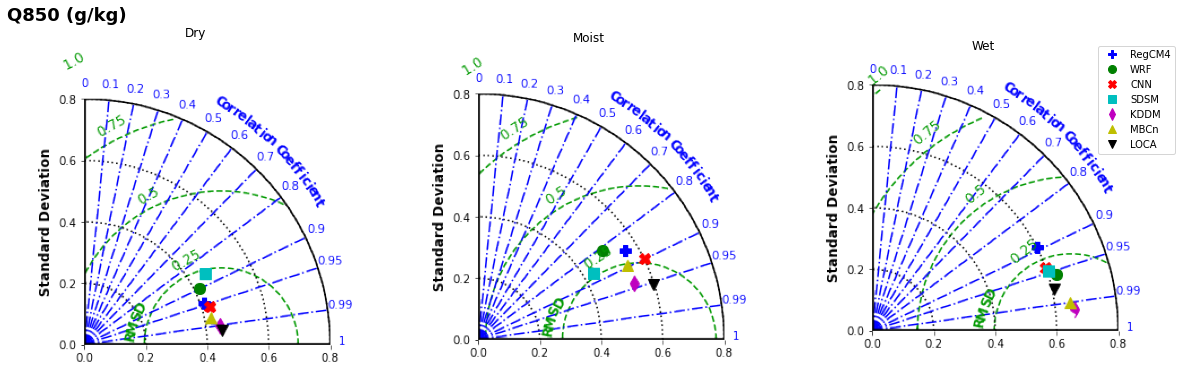

<Figure size 432x288 with 0 Axes>

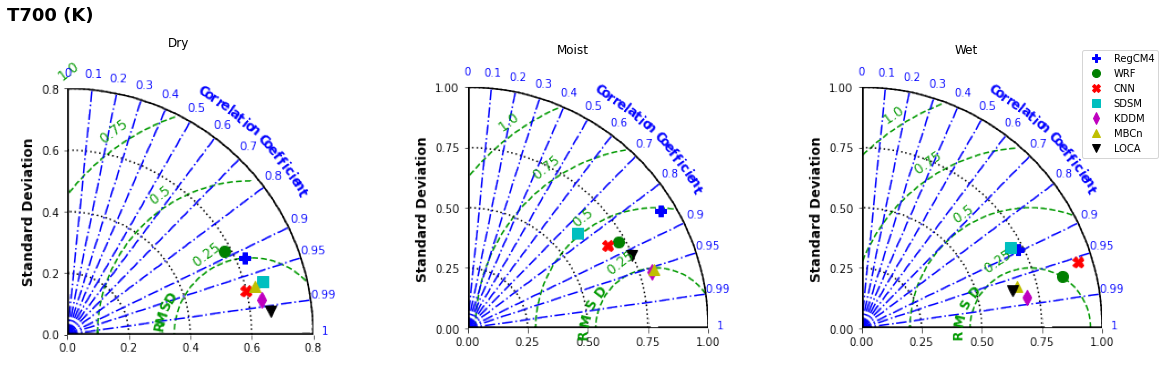

<Figure size 432x288 with 0 Axes>

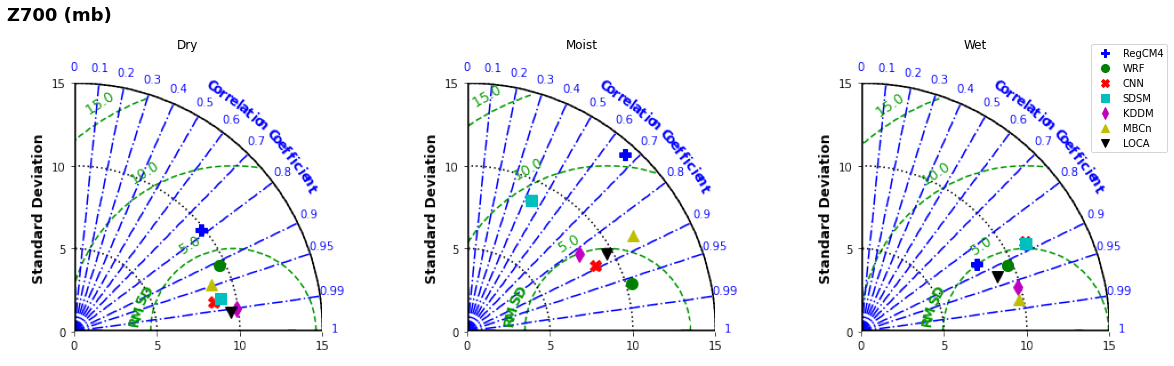

<Figure size 432x288 with 0 Axes>

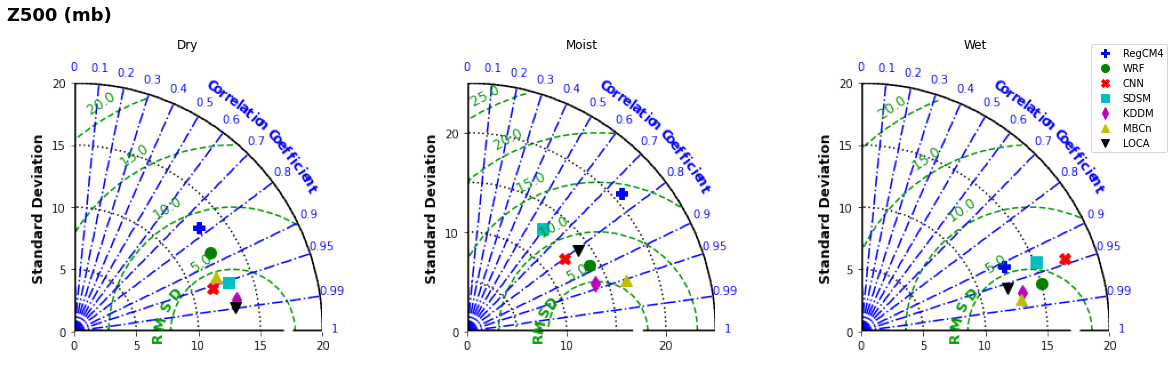

<Figure size 432x288 with 0 Axes>

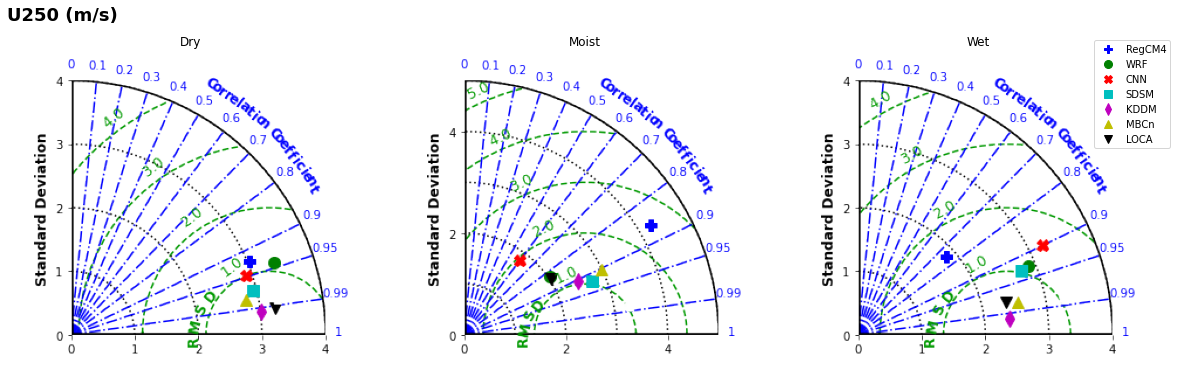

<Figure size 432x288 with 0 Axes>

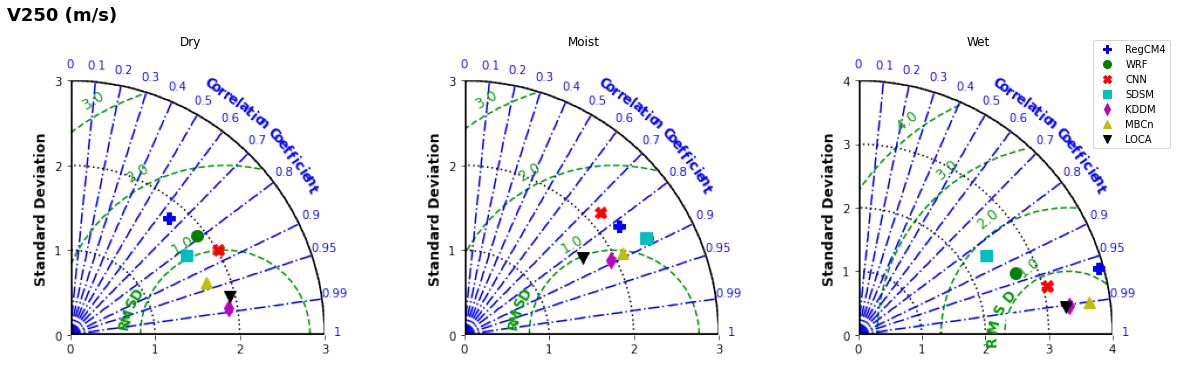

In [598]:
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['(m/s)', '(m/s)', '(g/kg)', '(K)', '(mb)', '(mb)', '(m/s)', '(m/s)']


for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    #buf4 = io.BytesIO()
    
    #print("Variable: ", varmames[vii], units[vii])
    
    # min/max
    maxxx = np.array(HAXX)[:,vii,0:2].max()
    maxxy = np.array(HAYY)[:,vii,0:2].max()
    maxxz = np.array(HAZZ)[:,vii,0:2].max()
    #print(maxxx, maxxy, maxxz)

    # col1
    aa = np.concatenate([np.array(XX)[:,vii,0], [maxxx]])
    bb = np.concatenate([np.array(YY)[:,vii,0], [maxxy]])
    cc = np.concatenate([np.array(ZZ)[:,vii,0], [maxxz]])
    dd = names + ['***']
    if vii in [0,2,3]: # Use custom ticks for U850, Q850, T700
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.25,.5,.75,1])
        #sm.taylor_diagram(aa, bb, cc, tickRMS=[.25,.5,.75,1], markerSize=0)
        #sm.taylor_diagram(aa[0:-1], bb[0:-1], cc[0:-1], markerLabel=dd[0:-1], overlay='on', tickRMS=[.25,.5,.75,1], markerLegend = 'on', markerSize=8)
        sm.taylor_diagram(aa, bb, cc, tickRMS=[.25,.5,.75,1], markerSize=0)
        for mii in range(len(aa)-1):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.25,.5,.75,1])
    else:
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
        #sm.taylor_diagram(aa, bb, cc, markerSize=0)
        #sm.taylor_diagram(aa[0:-1], bb[0:-1], cc[0:-1], markerLabel=dd[0:-1], overlay='on', markerLegend = 'on', markerSize=8)
        sm.taylor_diagram(aa, bb, cc, markerSize=0)
        for mii in range(len(aa)-1):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on') 
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_change_row{}_col{}.png'.format(vii+1,1), format='png', bbox_inches='tight', dpi=150)
    plt.clf()   # Clear figure
    

    # col2
    aa = np.concatenate([np.array(XX)[:,vii,1], [maxxx]])
    bb = np.concatenate([np.array(YY)[:,vii,1], [maxxy]])
    cc = np.concatenate([np.array(ZZ)[:,vii,1], [maxxz]])
    dd = names + ['***']
    if vii in [0,2,3]: # Use custom ticks for U850, Q850, T700
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.25,.5,.75,1])
        sm.taylor_diagram(aa, bb, cc, tickRMS=[.25,.5,.75,1], markerSize=0)
        for mii in range(len(aa)-1):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.25,.5,.75,1])
    else:
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
        sm.taylor_diagram(aa, bb, cc, markerSize=0)
        for mii in range(len(aa)-1):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_change_row{}_col{}.png'.format(vii+1,2), format='png', bbox_inches='tight', dpi=150)
    plt.clf()   # Clear figure  
    

    # col3
    aa = np.concatenate([np.array(XX)[:,vii,2], [maxxx]])
    bb = np.concatenate([np.array(YY)[:,vii,2], [maxxy]])
    cc = np.concatenate([np.array(ZZ)[:,vii,2], [maxxz]])
    dd = names + ['***']
    if vii in [0,2,3]: # Use custom ticks for U850, Q850, T700
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.25,.5,.75,1])
        sm.taylor_diagram(aa, bb, cc, tickRMS=[.25,.5,.75,1], markerSize=0)
        for mii in range(len(aa)-1):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.2,.4,.6,.8])
    else:
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
        sm.taylor_diagram(aa, bb, cc, markerSize=0)
        for mii in range(len(aa)-1):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_change_row{}_col{}.png'.format(vii+1,3), format='png', bbox_inches='tight', dpi=150)
    plt.clf()   # Clear figure
    
    
    # col4
    #aa = np.concatenate([np.array(XX)[:,vii,3], [maxxx]])
    #bb = np.concatenate([np.array(YY)[:,vii,3], [maxxy]])
    #cc = np.concatenate([np.array(ZZ)[:,vii,3], [maxxz]])
    #dd = names + ['***']
    #if vii in [0,2,3]: # Use custom ticks for U850, Q850, T700
    #    sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.25,.5,.75,1])
    #else:
    #    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #plt.savefig(buf4, format='png', bbox_inches='tight')
    #plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    #buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    #img4 = Image.open(buf4)
    

    # plot png inside a grid layout
    #fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize = (20,20/3))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Wet')
    
    #axarr[3].imshow(img4)
    #axarr[3].axis('off')
    #axarr[3].set_title('All (Mays)')
    
    # title
    fig.suptitle(str(varmames[vii])+' '+str(units[vii]), y=0.92, x=.15, fontsize=18, fontweight="bold")

    # custom legend
    import matplotlib.lines as mlines
    handles = []
    for ii in range(7):
        handles.append(mlines.Line2D([], [], color=list(label.values())[ii], marker=msymb[ii], linestyle='None', markersize=8, label=list(label.keys())[ii]))
    plt.legend(handles=handles, bbox_to_anchor=(1.1, 1.05))
    
    plt.show()


### row9 for Change Signal

In [588]:
# Calc row9

In [589]:
# find min/max on axis 0 (the var axis)
allYYMax = np.array(allYY).max(axis=2)
allYYMin = np.array(allYY).min(axis=2)

#allYYStd[noise == 0] = 1
np.array(allYY).shape, allYYMin.shape, (allYYMax-allYYMin).shape

((8, 4, 8, 18, 18), (8, 4, 18, 18), (8, 4, 18, 18))

In [590]:
allYYMax.min(), allYYMin.min()

(43.92078080657393, -6.970048931560514)

In [591]:
# normalize each var to 0-1
allYYNorm = (np.array(allYY) - allYYMin[:,:,np.newaxis,:,:]) / (allYYMax-allYYMin)[:,:,np.newaxis,:,:]  

# # replace nan's with .5 (mid range), this happens when min==max
# allYYNorm[np.isnan(allYYNorm)] = 0.5

allYYNorm.shape   # model, pr, var, 18x18

(8, 4, 8, 18, 18)

In [592]:
# average over all variables
allYYNormAvg = allYYNorm.mean(axis=2) 
allYYNormAvg.shape  # model, pr, 18x18

(8, 4, 18, 18)

In [593]:
# add row9
sd83=[]; cr83=[]; sc83=[]
for mii in range(8):
    sd3=[]; cr3=[]; sc3=[]
    for pii in range(4):            

        sd = np.std(allYYNormAvg[mii][pii] - allYYNorm[0][pii][mii])
        cr = ((allYYNormAvg[mii][pii] - allYYNorm[0][pii][mii])**2).mean()**0.5            
        sc, delme = spearmanr(allYYNorm[0][pii].flatten(), allYYNorm[mii][pii].flatten())

        sd3.append(float(sd))
        cr3.append(float(cr))
        sc3.append(float(sc))
        #print(mii, vii, float(sd), float(cr), float(sc))
    sd83.append(sd3)
    cr83.append(cr3)
    sc83.append(sc3)
    
sd83 = np.array(sd83)
cr83 = np.array(cr83)
sc83 = np.array(sc83)


In [594]:
sd83.shape

(8, 4)

<Figure size 432x288 with 0 Axes>

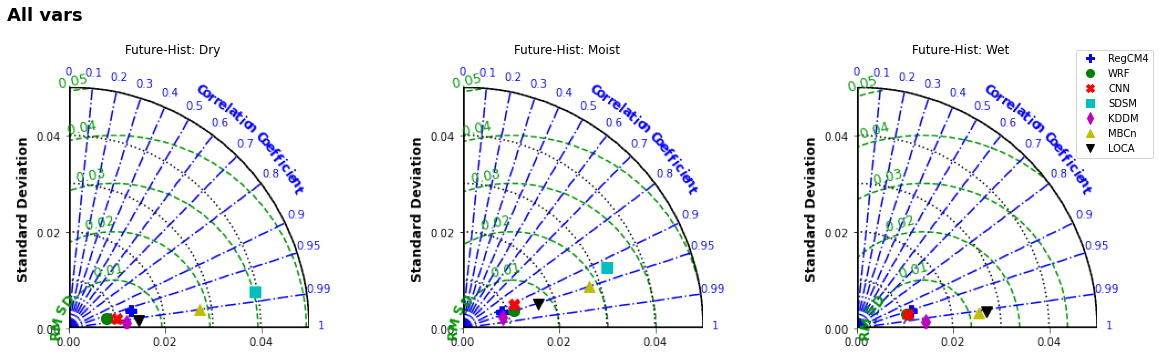

In [597]:
# Plot row9

# fake files to write to
buf1 = io.BytesIO()
buf2 = io.BytesIO()
buf3 = io.BytesIO()
buf4 = io.BytesIO()

#print("Variable: ", varmames[vii], units[vii])

# min/max
maxxx = sd83[:,0:3].max()
maxxy = cr83[:,0:3].max()
maxxz = sc83[:,0:3].max()
#print(maxxx, maxxy, maxxz)

# col1
aa = np.concatenate([sd83[:,0], [maxxx]])
bb = np.concatenate([cr83[:,0], [maxxy]])
cc = np.concatenate([sc83[:,0], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
plt.savefig(buf1, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,1), format='png', bbox_inches='tight')
plt.clf()   # Clear figure

# col2
aa = np.concatenate([sd83[:,1], [maxxx]])
bb = np.concatenate([cr83[:,1], [maxxy]])
cc = np.concatenate([sc83[:,1], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
plt.savefig(buf2, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,2), format='png', bbox_inches='tight')
plt.clf()   # Clear figure

# col3
aa = np.concatenate([sd83[:,2], [maxxx]])
bb = np.concatenate([cr83[:,2], [maxxy]])
cc = np.concatenate([sc83[:,2], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
plt.savefig(buf3, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,3), format='png', bbox_inches='tight')
plt.clf()   # Clear figure


# load png
buf1.seek(0)
buf2.seek(0)
buf3.seek(0)
#buf4.seek(0)
img1 = Image.open(buf1)
img2 = Image.open(buf2)
img3 = Image.open(buf3)
#img4 = Image.open(buf4)

# plot png inside a grid layout
#fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize = (20,20/3))

axarr[0].imshow(img1)
#axarr[0].axis('tight')
axarr[0].axis('off')
axarr[0].set_title('Future-Hist: Dry')

axarr[1].imshow(img2)
axarr[1].axis('off')
axarr[1].set_title('Future-Hist: Moist')

axarr[2].imshow(img3)
axarr[2].axis('off')
axarr[2].set_title('Future-Hist: Wet')

# #axarr[3].imshow(img4)
# #axarr[3].axis('off')
# #axarr[3].set_title('Rcp85 anom: All (Mays)')

# title
fig.suptitle('All vars', y=0.92, x=.15, fontsize=18, fontweight="bold")

# custom legend
import matplotlib.lines as mlines
handles = []
for ii in range(7):
    handles.append(mlines.Line2D([], [], color=list(label.values())[ii], marker=msymb[ii], linestyle='None', markersize=8, label=list(label.keys())[ii]))
plt.legend(handles=handles, bbox_to_anchor=(1.1, 1.05))

plt.show()

# Hist anomalies

In [ ]:
# # Calculate parameters for Taylor plots: Historical anomalies for dry/moist/wet/all

# names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
# sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
# sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# # interate over models
# HAXX=[]; HAYY=[]; HAZZ=[]
# for mii in range(len(sigfiles_hist)):
#     sigfn1 = sigfiles_hist[mii]
#     sigfn2 = sigfiles_rcp85[mii]

#     rainsignal1 = xr.open_dataset(sigfn1)['prec']
#     rainsignal2 = xr.open_dataset(sigfn2)['prec']

#     X=[]
#     load_uatm_mpi_hist()
#     for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
#         avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
#         #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
#         X.append(avginput_hist)
    
#     Y=[]
#     load_uatm_mpi_future()
#     for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
#         avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
#         Y.append(avginput_rcp85)
        
#     sd83=[]; cr83=[]; sc83=[]
#     for vii in range(8):
#         sd3=[]; cr3=[]; sc3=[]
#         for ii in range(4):
            
#             diff = X[ii] - X[3]
            
#             #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
#             sd = np.std(diff[vii])
#             cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
#             sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
#             sd3.append(float(sd))
#             cr3.append(float(cr))
#             sc3.append(float(sc))
#             #print(mii, vii, float(sd), float(cr), float(sc))
#         sd83.append(sd3)
#         cr83.append(cr3)
#         sc83.append(sc3)

#     HAXX.append(sd83)
#     HAYY.append(cr83)
#     HAZZ.append(sc83)


In [555]:
# Calculate parameters for Taylor plots: Historical anomalies for dry/moist/wet/all

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]


# interate over models
HAXX=[]; HAYY=[]; HAZZ=[]
allYY = []
for mii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[mii]
    rainsignal1 = xr.open_dataset(sigfn1)['prec']
            
    X=[]
    load_uatm_mpi_hist()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
        X.append(avginput_hist)
    allYY.append(X)
        
   
    # baseline: raw
    if mii == 0:
        baseline_hist = np.array(X[3])
 
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for ii in range(4):            
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            #cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
            #sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
            
            sd = np.std(np.array(Y[ii][vii]) - baseline_hist[vii])
            cr = ((np.array(X[ii][vii]) - baseline_hist[vii])**2).mean()**0.5            
            sc, delme = spearmanr(baseline_hist[vii].flatten(), np.array(X[ii][vii]).flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            #print(mii, vii, float(sd), float(cr), float(sc))
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)
        
    HAXX.append(sd83)
    HAYY.append(cr83)
    HAZZ.append(sc83)

<Figure size 432x288 with 0 Axes>

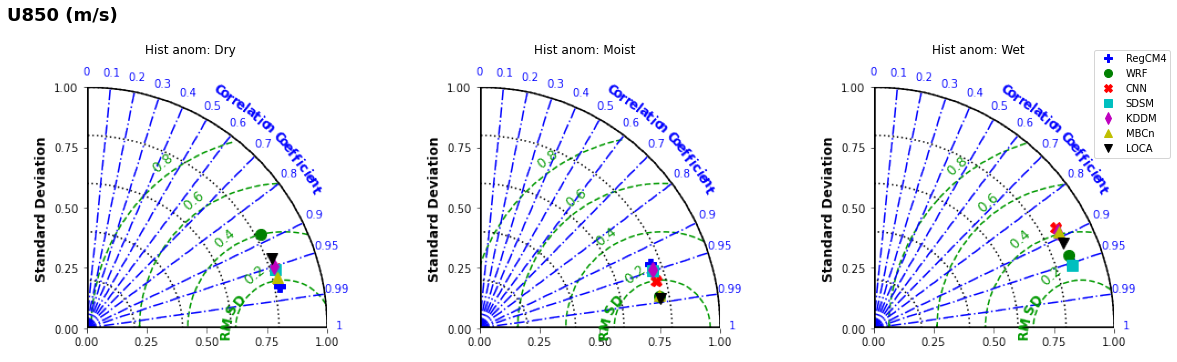

<Figure size 432x288 with 0 Axes>

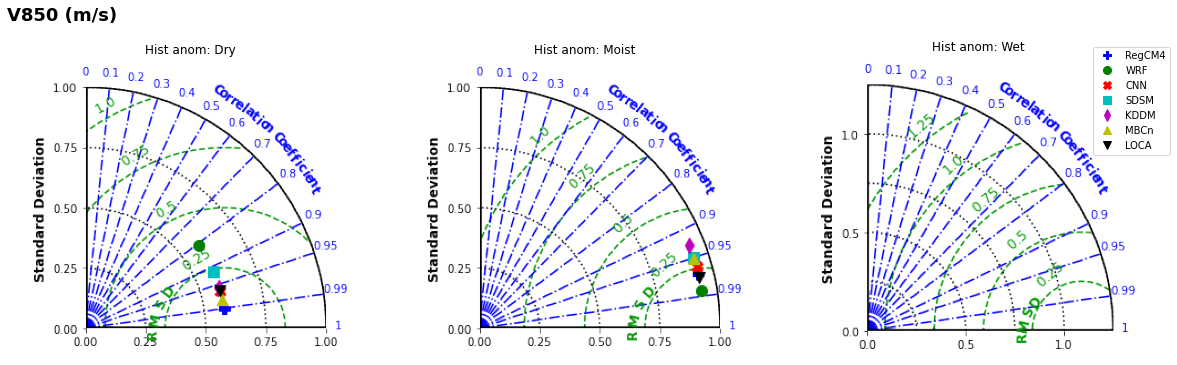

<Figure size 432x288 with 0 Axes>

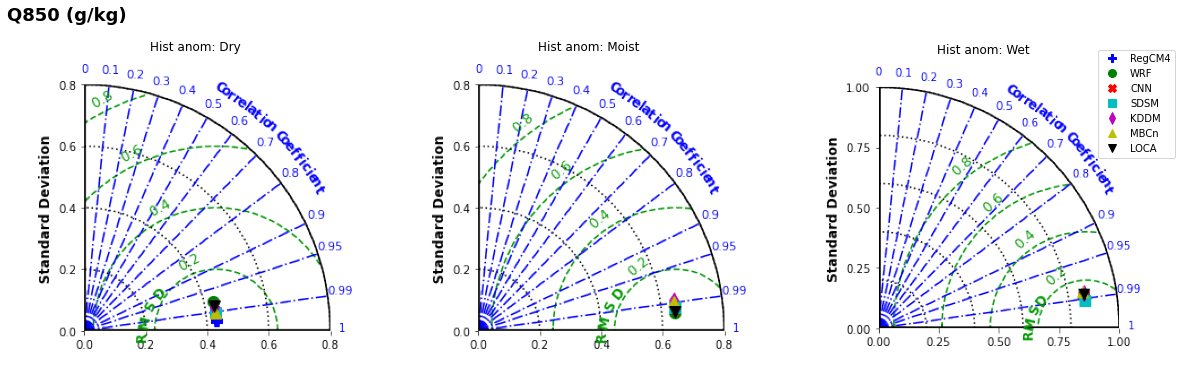

<Figure size 432x288 with 0 Axes>

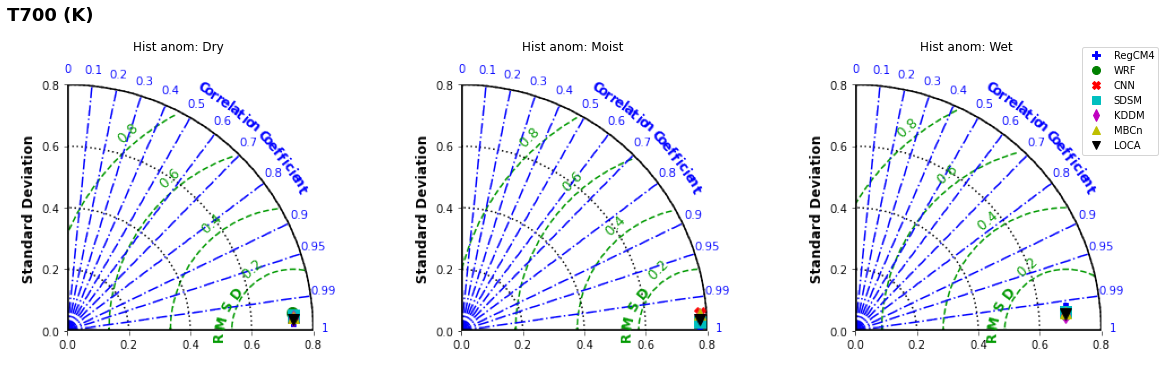

<Figure size 432x288 with 0 Axes>

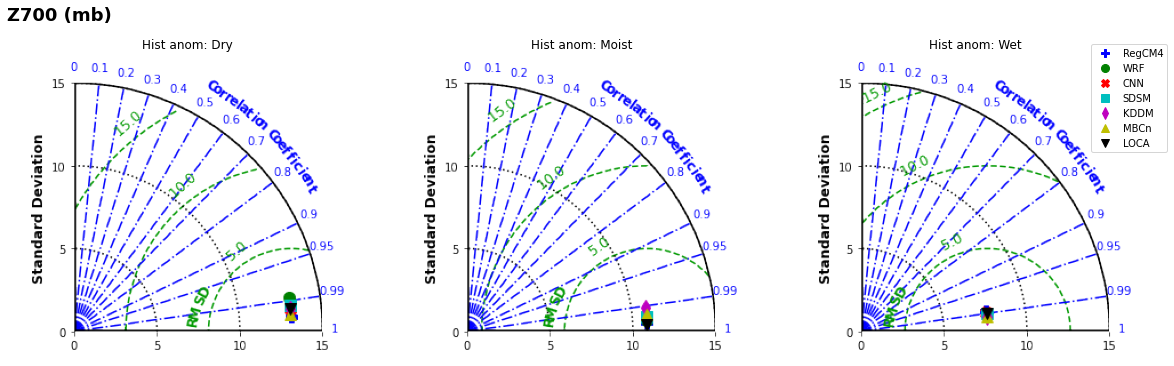

<Figure size 432x288 with 0 Axes>

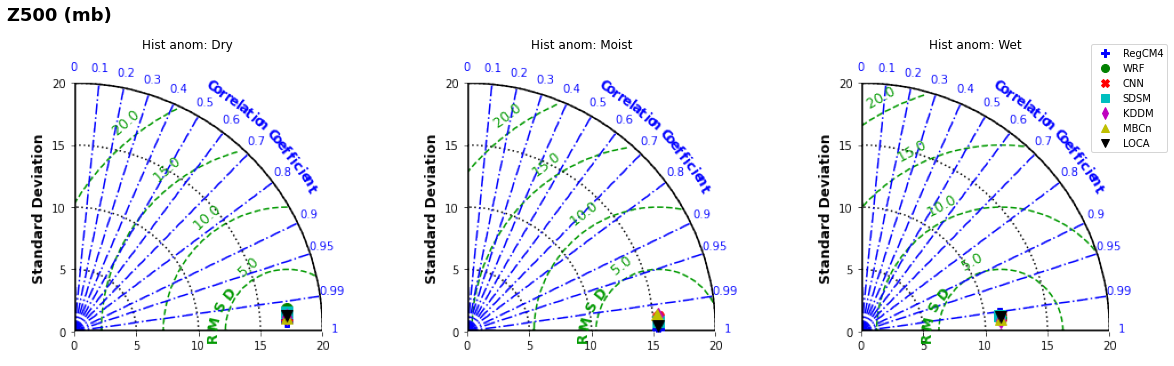

<Figure size 432x288 with 0 Axes>

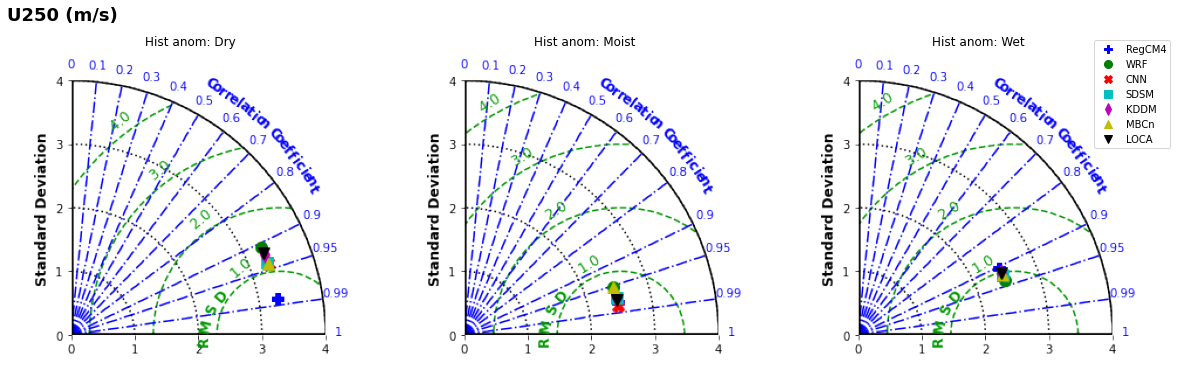

<Figure size 432x288 with 0 Axes>

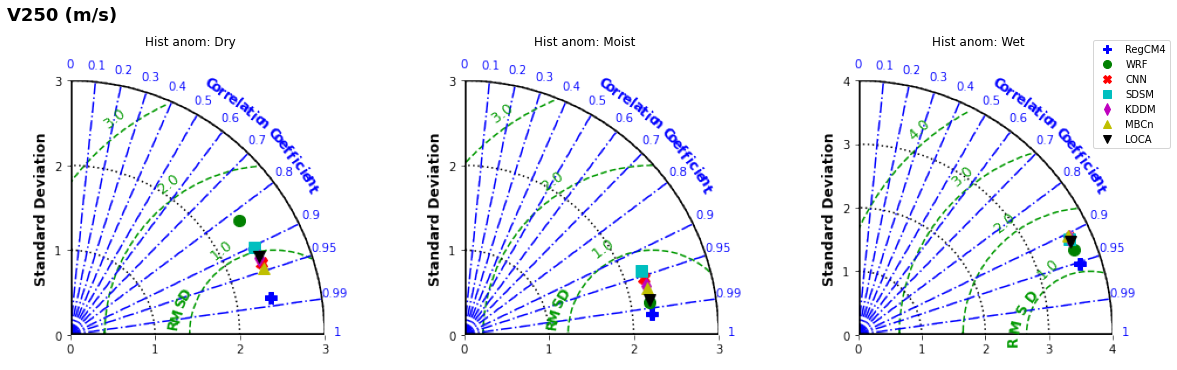

In [556]:
# Plot hist anomalies
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['(m/s)', '(m/s)', '(g/kg)', '(K)', '(mb)', '(mb)', '(m/s)', '(m/s)']

for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    buf4 = io.BytesIO()
    
    #print("Variable: ", varmames[vii], units[vii])
    
    # min/max
    maxxx = np.array(HAXX)[:,vii,0:2].max()
    maxxy = np.array(HAYY)[:,vii,0:2].max()
    maxxz = np.array(HAZZ)[:,vii,0:2].max()
    #print(maxxx, maxxy, maxxz)

    # col1
    aa = np.concatenate([np.array(HAXX)[:,vii,0], [maxxx]])
    bb = np.concatenate([np.array(HAYY)[:,vii,0], [maxxy]])
    cc = np.concatenate([np.array(HAZZ)[:,vii,0], [maxxz]])
    dd = names + ['***']
    if vii in [0, 2, 3]: # Use custom ticks for U850, Q850 and T700
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.2,.4,.6,.8])
        #sm.taylor_diagram(aa, bb, cc, tickRMS=[.2,.4,.6,.8], markerSize=0)
        #sm.taylor_diagram(aa[0:-1], bb[0:-1], cc[0:-1], markerLabel=dd[0:-1], overlay='on', tickRMS=[.2,.4,.6,.8], markerLegend = 'on', markerSize=8)
        sm.taylor_diagram(aa, bb, cc, tickRMS=[.2,.4,.6,.8], markerSize=0)
        for mii in range(len(aa)-2):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.2,.4,.6,.8])       
    else:
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
        #sm.taylor_diagram(aa, bb, cc, markerSize=0)
        #sm.taylor_diagram(aa[0:-1], bb[0:-1], cc[0:-1], markerLabel=dd[0:-1], overlay='on', markerLegend = 'on', markerSize=8)
        sm.taylor_diagram(aa, bb, cc, markerSize=0)
        for mii in range(len(aa)-2):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')

        
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_hist_row{}_col{}.png'.format(vii+1,1), format='png', bbox_inches='tight')
    plt.clf()   # Clear figure
    

    
    # col2
    aa = np.concatenate([np.array(HAXX)[:,vii,1], [maxxx]])
    bb = np.concatenate([np.array(HAYY)[:,vii,1], [maxxy]])
    cc = np.concatenate([np.array(HAZZ)[:,vii,1], [maxxz]])
    dd = names + ['***']
    if vii in [0, 2, 3]: # Use custom ticks for U850, Q850 and T700
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.2,.4,.6,.8])
        sm.taylor_diagram(aa, bb, cc, tickRMS=[.2,.4,.6,.8], markerSize=0)
        for mii in range(len(aa)-2):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.2,.4,.6,.8])
    else:
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
        sm.taylor_diagram(aa, bb, cc, markerSize=0)
        for mii in range(len(aa)-2):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_hist_row{}_col{}.png'.format(vii+1,2), format='png', bbox_inches='tight')
    plt.clf()   # Clear figure        

    # col3
    aa = np.concatenate([np.array(HAXX)[:,vii,2], [maxxx]])
    bb = np.concatenate([np.array(HAYY)[:,vii,2], [maxxy]])
    cc = np.concatenate([np.array(HAZZ)[:,vii,2], [maxxz]])
    dd = names + ['***']
    if vii in [0, 2, 3]: # Use custom ticks for U850, Q850 and T700
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.2,.4,.6,.8])
        sm.taylor_diagram(aa, bb, cc, tickRMS=[.2,.4,.6,.8], markerSize=0)
        for mii in range(len(aa)-2):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.2,.4,.6,.8])
    else:
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
        sm.taylor_diagram(aa, bb, cc, markerSize=0)
        for mii in range(len(aa)-2):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_hist_row{}_col{}.png'.format(vii+1,3), format='png', bbox_inches='tight')
    plt.clf()   # Clear figure
    
    

    ## col4
    #aa = np.concatenate([np.array(HAXX)[:,vii,3], [maxxx]])
    #bb = np.concatenate([np.array(HAYY)[:,vii,3], [maxxy]])
    #cc = np.concatenate([np.array(HAZZ)[:,vii,3], [maxxz]])
    #dd = names + ['***']
    #if vii in [0, 2, 3]: # Use custom ticks for U850, Q850 and T700
    #    sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.2,.4,.6,.8])
    #else:
    #    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #plt.savefig(buf4, format='png', bbox_inches='tight')
    #plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    #buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    #img4 = Image.open(buf4)

    # plot png inside a grid layout
    #fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize = (20,20/3))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Hist anom: Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Hist anom: Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Hist anom: Wet')
    
    #axarr[3].imshow(img4)
    #axarr[3].axis('off')
    #axarr[3].set_title('Hist anom: All (Mays)')
    
    # title
    fig.suptitle(str(varmames[vii])+' '+str(units[vii]), y=0.92, x=.15, fontsize=18, fontweight="bold")

    # custom legend
    import matplotlib.lines as mlines
    handles = []
    for ii in range(7):
        handles.append(mlines.Line2D([], [], color=list(label.values())[ii], marker=msymb[ii], linestyle='None', markersize=8, label=list(label.keys())[ii]))
    plt.legend(handles=handles, bbox_to_anchor=(1.1, 1.05))
    
    plt.show()

### row9 for Historical anomalies

In [557]:
np.array(allYY).shape # model, pr range, var, 18x18 

(8, 4, 8, 18, 18)

In [559]:
# Calc row9

In [560]:
# find min/max on axis 0 (the var axis)
allYYMax = np.array(allYY).max(axis=2)
allYYMin = np.array(allYY).min(axis=2)

#allYYStd[noise == 0] = 1
np.array(allYY).shape, allYYMin.shape, (allYYMax-allYYMin).shape

((8, 4, 8, 18, 18), (8, 4, 18, 18), (8, 4, 18, 18))

In [561]:
allYYMax.min(), allYYMin.min()

(5487.189293032787, -8.684108990069015)

In [562]:
# normalize each var to 0-1
allYYNorm = (np.array(allYY) - allYYMin[:,:,np.newaxis,:,:]) / (allYYMax-allYYMin)[:,:,np.newaxis,:,:]  

# # replace nan's with .5 (mid range), this happens when min==max
# allYYNorm[np.isnan(allYYNorm)] = 0.5

allYYNorm.shape   # model, pr, var, 18x18

(8, 4, 8, 18, 18)

In [563]:
# average over all variables
allYYNormAvg = allYYNorm.mean(axis=2) 
allYYNormAvg.shape  # model, pr, 18x18

(8, 4, 18, 18)

In [564]:
# add row9
sd83=[]; cr83=[]; sc83=[]
for mii in range(8):
    sd3=[]; cr3=[]; sc3=[]
    for pii in range(4):            

        sd = np.std(allYYNormAvg[mii][pii] - allYYNorm[0][pii][mii])
        cr = ((allYYNormAvg[mii][pii] - allYYNorm[0][pii][mii])**2).mean()**0.5            
        sc, delme = spearmanr(allYYNorm[0][pii].flatten(), allYYNorm[mii][pii].flatten())

        sd3.append(float(sd))
        cr3.append(float(cr))
        sc3.append(float(sc))
        #print(mii, vii, float(sd), float(cr), float(sc))
    sd83.append(sd3)
    cr83.append(cr3)
    sc83.append(sc3)
    
sd83 = np.array(sd83)
cr83 = np.array(cr83)
sc83 = np.array(sc83)


In [566]:
sd83.shape

(8, 4)

<Figure size 432x288 with 0 Axes>

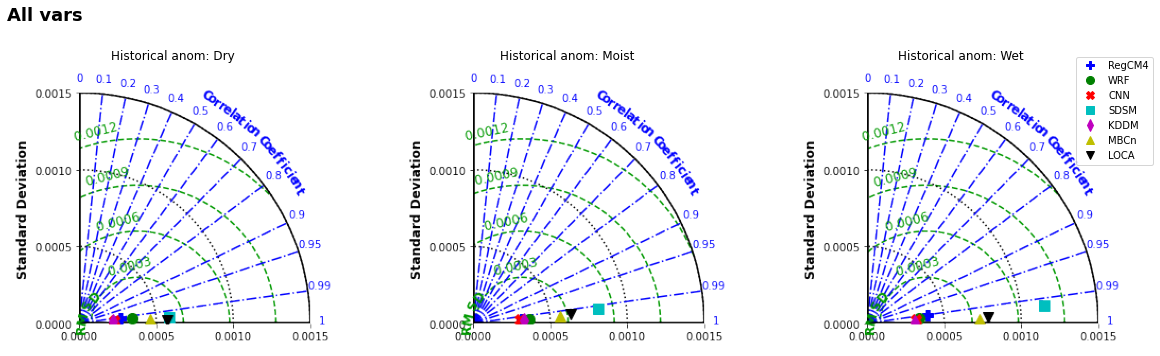

In [581]:
# Plot row9

# fake files to write to
buf1 = io.BytesIO()
buf2 = io.BytesIO()
buf3 = io.BytesIO()
buf4 = io.BytesIO()

#print("Variable: ", varmames[vii], units[vii])

# min/max
maxxx = sd83[:,0:3].max()
maxxy = cr83[:,0:3].max()
maxxz = sc83[:,0:3].max()
#print(maxxx, maxxy, maxxz)

# col1
aa = np.concatenate([sd83[:,0], [maxxx]])
bb = np.concatenate([cr83[:,0], [maxxy]])
cc = np.concatenate([sc83[:,0], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], tickRMS=[.0003, .0006, .0009, .0012], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
plt.savefig(buf1, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,1), format='png', bbox_inches='tight')
plt.clf()   # Clear figure

# col2
aa = np.concatenate([sd83[:,1], [maxxx]])
bb = np.concatenate([cr83[:,1], [maxxy]])
cc = np.concatenate([sc83[:,1], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], tickRMS=[.0003, .0006, .0009, .0012], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
plt.savefig(buf2, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,2), format='png', bbox_inches='tight')
plt.clf()   # Clear figure

# col3
aa = np.concatenate([sd83[:,2], [maxxx]])
bb = np.concatenate([cr83[:,2], [maxxy]])
cc = np.concatenate([sc83[:,2], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], tickRMS=[.0003, .0006, .0009, .0012], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
plt.savefig(buf3, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,3), format='png', bbox_inches='tight')
plt.clf()   # Clear figure


# load png
buf1.seek(0)
buf2.seek(0)
buf3.seek(0)
#buf4.seek(0)
img1 = Image.open(buf1)
img2 = Image.open(buf2)
img3 = Image.open(buf3)
#img4 = Image.open(buf4)

# plot png inside a grid layout
#fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize = (20,20/3))

axarr[0].imshow(img1)
#axarr[0].axis('tight')
axarr[0].axis('off')
axarr[0].set_title('Historical anom: Dry')

axarr[1].imshow(img2)
axarr[1].axis('off')
axarr[1].set_title('Historical anom: Moist')

axarr[2].imshow(img3)
axarr[2].axis('off')
axarr[2].set_title('Historical anom: Wet')

# #axarr[3].imshow(img4)
# #axarr[3].axis('off')
# #axarr[3].set_title('Rcp85 anom: All (Mays)')

# title
fig.suptitle('All vars', y=0.92, x=.15, fontsize=18, fontweight="bold")

# custom legend
import matplotlib.lines as mlines
handles = []
for ii in range(7):
    handles.append(mlines.Line2D([], [], color=list(label.values())[ii], marker=msymb[ii], linestyle='None', markersize=8, label=list(label.keys())[ii]))
plt.legend(handles=handles, bbox_to_anchor=(1.1, 1.05))

plt.show()

# Future anomalies

In [459]:
FAZZ[0]

[[0.9620636306704421, 0.9681522055515864, 0.8645966852778, 1.0],
 [0.9905501309835676, 0.9754340098612546, 0.9374736489287575, 1.0],
 [0.9875451827154615, 0.9928250994504865, 0.9844880174291941, 1.0],
 [0.9989291983100033, 0.9995392200964959, 0.9971802810192903, 1.0],
 [0.9969844672011857, 0.9980941668734364, 0.9917126652730368, 1.0],
 [0.9986518836054442, 0.9994182036287299, 0.995440889806215, 1.0],
 [0.9193613999805951, 0.981433674684449, 0.842784437211682, 1.0],
 [0.8835207677312942, 0.9223003713406192, 0.7274441004471967, 1.0]]

In [599]:
# Calculate parameters for Taylor plots: dry/moist/wet

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

load_uatm_mpi_future()

# interate over models
FAXX=[]; FAYY=[]; FAZZ=[]
allYY = []
for mii in range(len(sigfiles_rcp85)):
    sigfn2 = sigfiles_rcp85[mii]
    rainsignal2 = xr.open_dataset(sigfn2)['prec']
              
    allY=[]
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
        allY.append(avginput_rcp85)
    allYY.append(allY)
   
    # baseline: raw
    if mii == 0:
        baseline_future = np.array(allY[3])

 
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for pii in range(4):            
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            #cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
            #sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
            
            sd = np.std(np.array(allYY[mii][pii][vii]) - baseline_future[vii])
            cr = ((np.array(allYY[mii][pii][vii]) - baseline_future[vii])**2).mean()**0.5            
            sc, delme = spearmanr(baseline_future[vii].flatten(), np.array(allYY[mii][pii][vii]).flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            #print(mii, vii, float(sd), float(cr), float(sc))
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)
        
    FAXX.append(sd83)
    FAYY.append(cr83)
    FAZZ.append(sc83)

<Figure size 432x288 with 0 Axes>

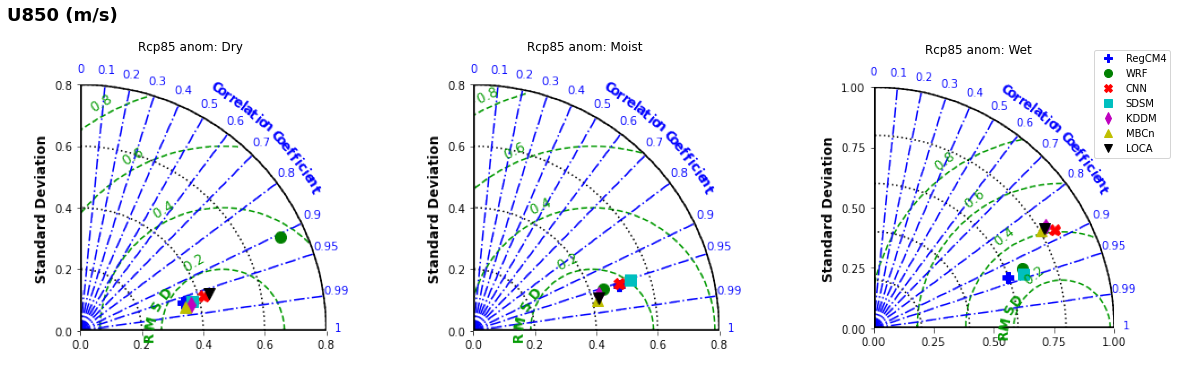

<Figure size 432x288 with 0 Axes>

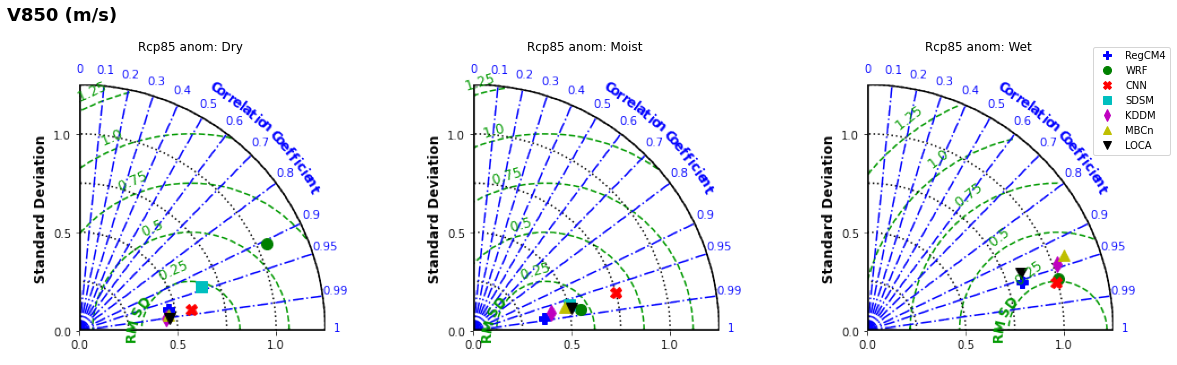

<Figure size 432x288 with 0 Axes>

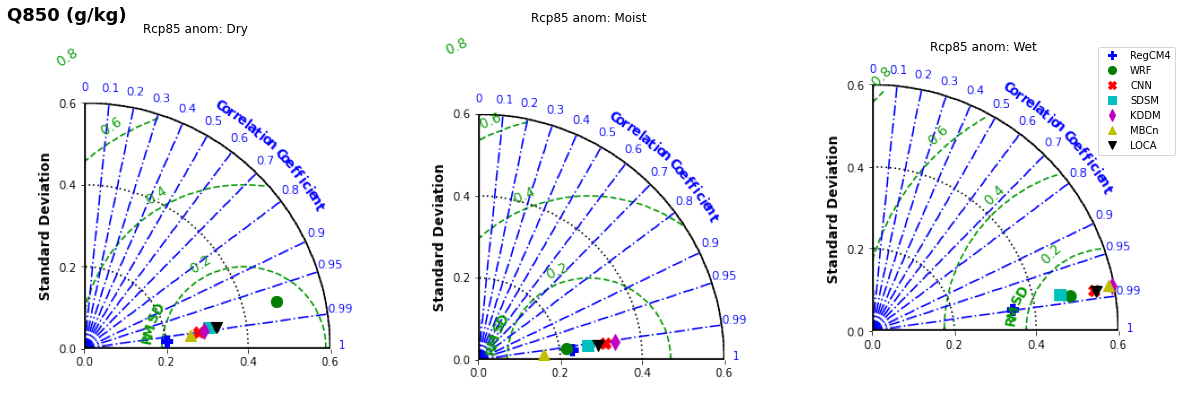

<Figure size 432x288 with 0 Axes>

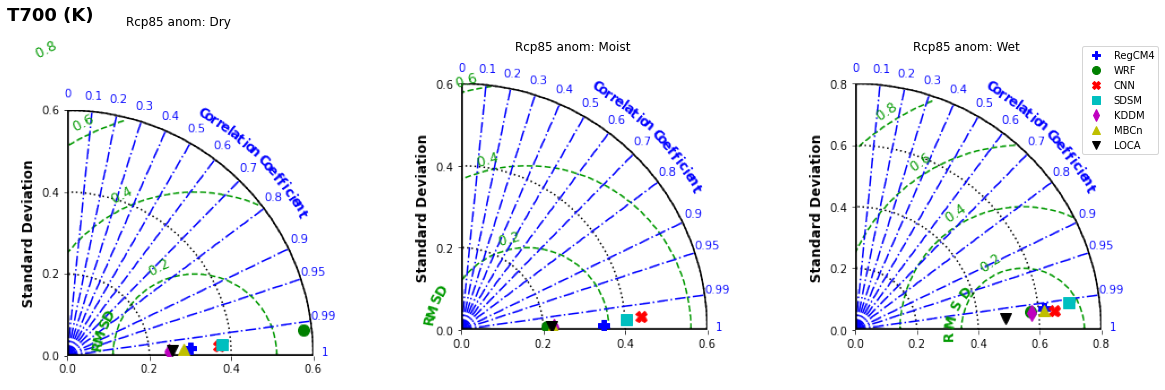

<Figure size 432x288 with 0 Axes>

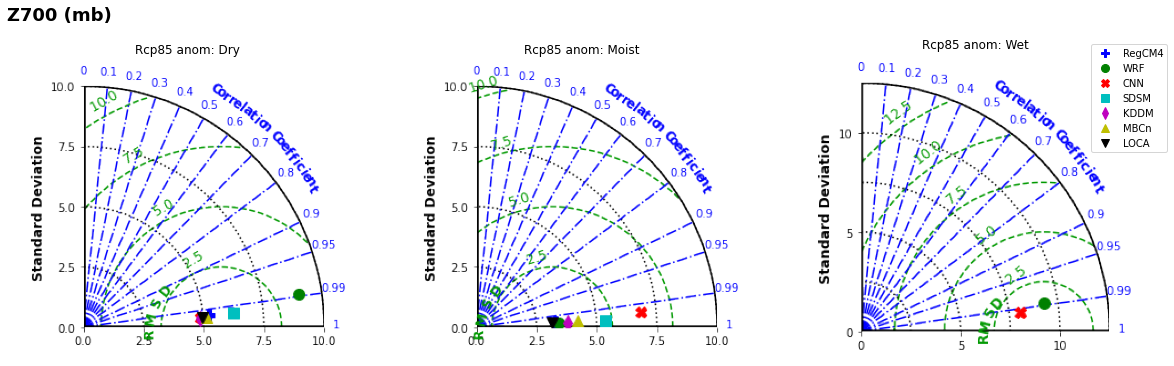

<Figure size 432x288 with 0 Axes>

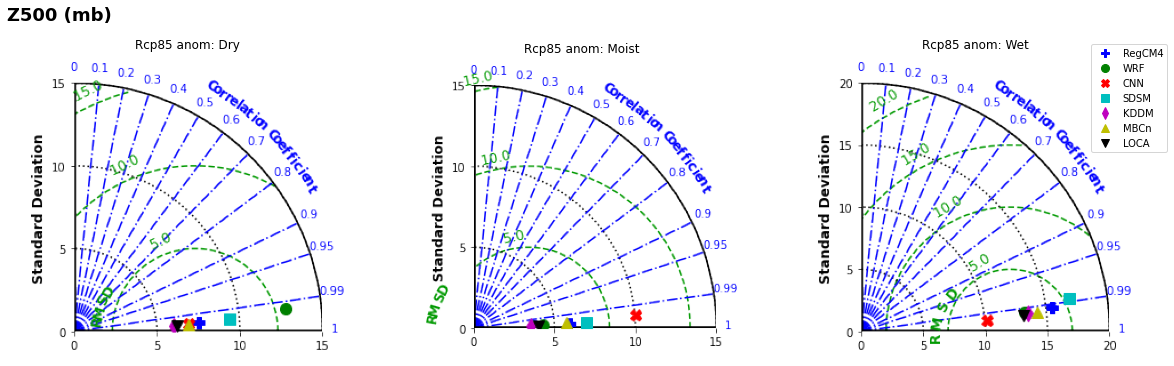

<Figure size 432x288 with 0 Axes>

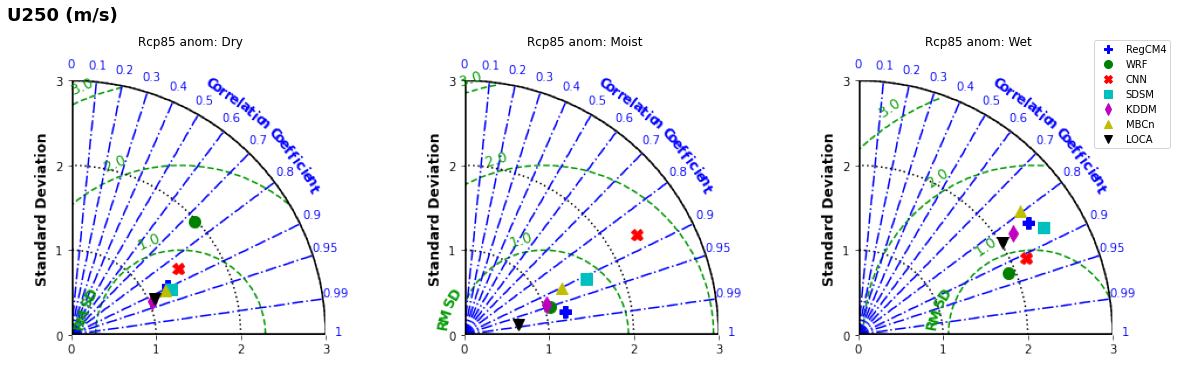

<Figure size 432x288 with 0 Axes>

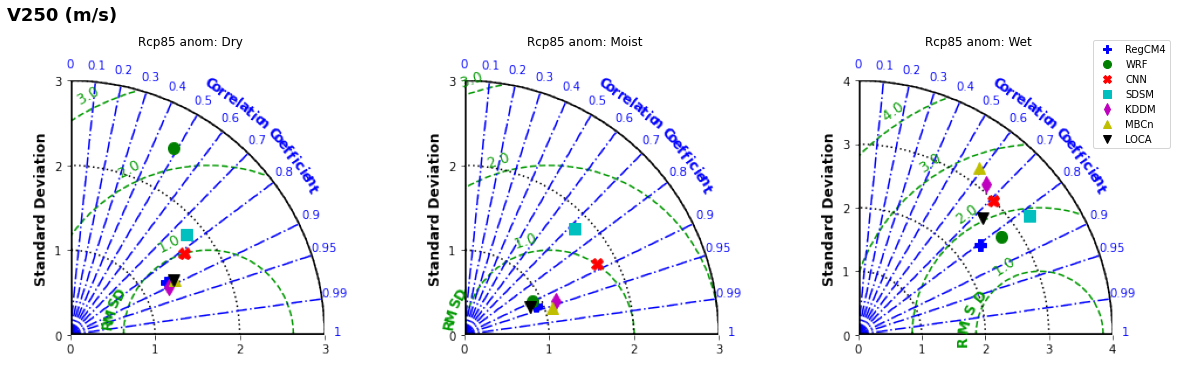

In [600]:
# Plot Future anomalies
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250', 'all']
units = ['(m/s)', '(m/s)', '(g/kg)', '(K)', '(mb)', '(mb)', '(m/s)', '(m/s)', '']

# model colors
mcolor = ['b','g','r','c','m','y','k','w']
#names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
#label = {'RegCM4':'b', 'WRF':'g', 'CNN':'r', 'SDSM':'c', 'KDDM':'m', 'MBCn': 'y', 'LOCA': 'k'} 


msymb = ['P','o','X','s','d','^','v','p']

for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    buf4 = io.BytesIO()
    
    #print("Variable: ", varmames[vii], units[vii])
    
    # min/max
    maxxx = np.array(FAXX)[:,vii,0:2].max()
    maxxy = np.array(FAYY)[:,vii,0:2].max()
    maxxz = np.array(FAZZ)[:,vii,0:2].max()
    #print(maxxx, maxxy, maxxz)

    # col1
    aa = np.concatenate([np.array(FAXX)[:,vii,0], [maxxx]])
    bb = np.concatenate([np.array(FAYY)[:,vii,0], [maxxy]])
    cc = np.concatenate([np.array(FAZZ)[:,vii,0], [maxxz]])
    dd = names + ['***']
    if vii in [0, 2, 3]: # Use custom ticks for U850, Q850 and T700
        #sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], tickRMS=[.2,.4,.6,.8], markerSize=0)
        #sm.taylor_diagram(aa[0:8], bb[0:8], cc[0:8], markerLabel=dd[0:8], overlay='on', tickRMS=[.2,.4,.6,.8], markerLegend = 'on', markerSize=8)
        sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], tickRMS=[.2,.4,.6,.8], markerSize=0)
        for mii in range(7):
            #sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], markerLabel=label, overlay='on', tickRMS=[.2,.4,.6,.8])
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.2,.4,.6,.8])
    else:
        #sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
        #sm.taylor_diagram(aa[0:8], bb[0:8], cc[0:8], markerLabel=dd[0:8], overlay='on', markerLegend = 'on', markerSize=8)
        sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
        for mii in range(7):
            #sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], markerLabel=label, overlay='on')
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,1), format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    # col2
    aa = np.concatenate([np.array(FAXX)[:,vii,1], [maxxx]])
    bb = np.concatenate([np.array(FAYY)[:,vii,1], [maxxy]])
    cc = np.concatenate([np.array(FAZZ)[:,vii,1], [maxxz]])
    dd = names + ['***']
    if vii in [0, 2, 3]: # Use custom ticks for U850, Q850 and T700
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.2,.4,.6,.8])
        sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], tickRMS=[.2,.4,.6,.8], markerSize=0)
        for mii in range(7):
            #sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], markerLabel=label, overlay='on', tickRMS=[.2,.4,.6,.8])
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.2,.4,.6,.8])
    else:
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
        sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
        for mii in range(7):
            #sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], markerLabel=label, overlay='on')
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')

    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,2), format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    # col3
    aa = np.concatenate([np.array(FAXX)[:,vii,2], [maxxx]])
    bb = np.concatenate([np.array(FAYY)[:,vii,2], [maxxy]])
    cc = np.concatenate([np.array(FAZZ)[:,vii,2], [maxxz]])
    dd = names + ['***']
    if vii in [0, 2, 3]: # Use custom ticks for U850, Q850 and T700
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.2,.4,.6,.8])
        sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], tickRMS=[.2,.4,.6,.8], markerSize=0)
        for mii in range(7):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.2,.4,.6,.8])
    else:
        #sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
        sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
        for mii in range(7):
            sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,3), format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    ## col4
    #aa = np.concatenate([np.array(FAXX)[:,vii,3], [maxxx]])
    #bb = np.concatenate([np.array(FAYY)[:,vii,3], [maxxy]])
    #cc = np.concatenate([np.array(FAZZ)[:,vii,3], [maxxz]])
    #dd = names + ['***']
    #if vii in [0, 2, 3]: # Use custom ticks for U850, Q850 and T700
    #    sm.taylor_diagram(aa, bb, cc, markerLabel=dd, tickRMS=[.2,.4,.6,.8])
    #else:
    #    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #plt.savefig(buf4, format='png', bbox_inches='tight')
    #plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    #buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    #img4 = Image.open(buf4)

    # plot png inside a grid layout
    #fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize = (20,20/3))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Rcp85 anom: Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Rcp85 anom: Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Rcp85 anom: Wet')
    
    #axarr[3].imshow(img4)
    #axarr[3].axis('off')
    #axarr[3].set_title('Rcp85 anom: All (Mays)')
    
    # title
    fig.suptitle(str(varmames[vii])+' '+str(units[vii]), y=0.92, x=.15, fontsize=18, fontweight="bold")
    
    # custom legend
    import matplotlib.lines as mlines
    handles = []
    for ii in range(7):
        handles.append(mlines.Line2D([], [], color=list(label.values())[ii], marker=msymb[ii], linestyle='None', markersize=8, label=list(label.keys())[ii]))
    plt.legend(handles=handles, bbox_to_anchor=(1.1, 1.05))

    plt.show()

### row9 for future anomalies

In [601]:
np.array(allYY).shape # model, pr range, var, 18x18 

(8, 4, 8, 18, 18)

In [602]:
np.array(FAXX).shape # model, pr range, var, 18x18 

(8, 8, 4)

In [603]:
# Calc row9

In [604]:
# find min/max on axis 0 (the var axis)
allYYMax = np.array(allYY).max(axis=2)
allYYMin = np.array(allYY).min(axis=2)

#allYYStd[noise == 0] = 1
np.array(allYY).shape, allYYMin.shape, (allYYMax-allYYMin).shape

((8, 4, 8, 18, 18), (8, 4, 18, 18), (8, 4, 18, 18))

In [605]:
allYYMax.min(), allYYMin.min()

(5554.487581623134, -6.585132271902902)

In [606]:
# normalize each var to 0-1
allYYNorm = (np.array(allYY) - allYYMin[:,:,np.newaxis,:,:]) / (allYYMax-allYYMin)[:,:,np.newaxis,:,:]  

# # replace nan's with .5 (mid range), this happens when min==max
# allYYNorm[np.isnan(allYYNorm)] = 0.5

allYYNorm.shape   # model, pr, var, 18x18

(8, 4, 8, 18, 18)

In [607]:
# average over all variables
allYYNormAvg = allYYNorm.mean(axis=2) 
allYYNormAvg.shape  # model, pr, 18x18

(8, 4, 18, 18)

In [608]:
# add row9
sd83=[]; cr83=[]; sc83=[]
for mii in range(8):
    sd3=[]; cr3=[]; sc3=[]
    for pii in range(4):            

        sd = np.std(allYYNormAvg[mii][pii] - allYYNorm[0][pii][mii])
        cr = ((allYYNormAvg[mii][pii] - allYYNorm[0][pii][mii])**2).mean()**0.5            
        sc, delme = spearmanr(allYYNorm[0][pii].flatten(), allYYNorm[mii][pii].flatten())

        sd3.append(float(sd))
        cr3.append(float(cr))
        sc3.append(float(sc))
        #print(mii, vii, float(sd), float(cr), float(sc))
    sd83.append(sd3)
    cr83.append(cr3)
    sc83.append(sc3)
    
sd83 = np.array(sd83)
cr83 = np.array(cr83)
sc83 = np.array(sc83)


In [609]:
sd83.shape, np.array(FAXX).shape

((8, 4), (8, 8, 4))

In [610]:
np.array(sd83[pii]), np.array(cr83[pii]), np.array(sc83[pii])

(array([0.00023921, 0.00028026, 0.00038625, 0.00026476]),
 array([0.15107361, 0.15115854, 0.1513127 , 0.15115744]),
 array([0.99854934, 0.99562023, 0.99539423, 0.99992695]))

In [611]:
sd83.shape

(8, 4)

0.0009625441238182969 0.800702288544353 1.0


<Figure size 432x288 with 0 Axes>

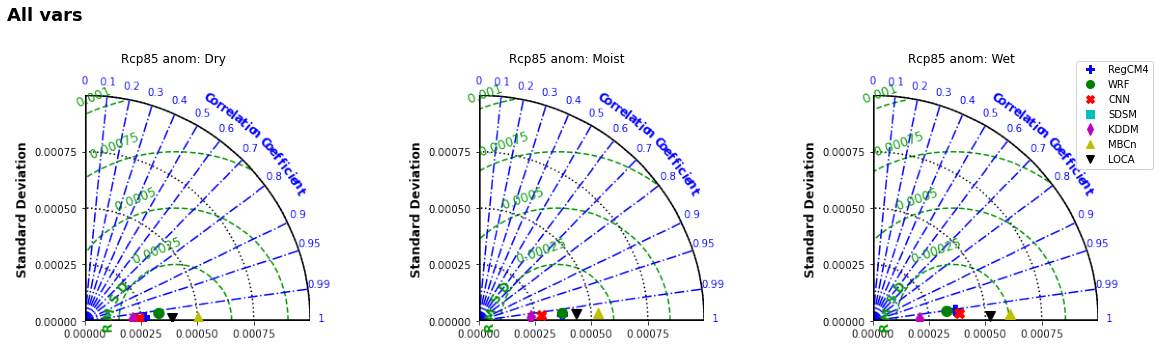

In [612]:
# Plot row9

# fake files to write to
buf1 = io.BytesIO()
buf2 = io.BytesIO()
buf3 = io.BytesIO()
buf4 = io.BytesIO()

#print("Variable: ", varmames[vii], units[vii])

# min/max
maxxx = sd83[:,0:2].max()
maxxy = cr83[:,0:2].max()
maxxz = sc83[:,0:2].max()
print(maxxx, maxxy, maxxz)

# col1
aa = np.concatenate([sd83[:,0], [maxxx]])
bb = np.concatenate([cr83[:,0], [maxxy]])
cc = np.concatenate([sc83[:,0], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
plt.savefig(buf1, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,1), format='png', bbox_inches='tight')
plt.clf()   # Clear figure

# col2
aa = np.concatenate([sd83[:,1], [maxxx]])
bb = np.concatenate([cr83[:,1], [maxxy]])
cc = np.concatenate([sc83[:,1], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on')
plt.savefig(buf2, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,2), format='png', bbox_inches='tight')
plt.clf()   # Clear figure

# col3
aa = np.concatenate([sd83[:,2], [maxxx]])
bb = np.concatenate([cr83[:,2], [maxxy]])
cc = np.concatenate([sc83[:,2], [maxxx]])
dd = names + ['***']
sm.taylor_diagram(aa[0:9], bb[0:9], cc[0:9], markerSize=0)
for mii in range(7):
    sm.taylor_diagram(aa[[0, mii+1]], bb[[0, mii+1]], cc[[0, mii+1]], markercolor=mcolor[mii], markerSymbol=msymb[mii], overlay='on', tickRMS=[.2,.4,.6,.8])
plt.savefig(buf3, format='png', bbox_inches='tight')
plt.savefig(jpg_outdir+'/taylor_rcp85_row{}_col{}.png'.format(vii+1,3), format='png', bbox_inches='tight')
plt.clf()   # Clear figure


# load png
buf1.seek(0)
buf2.seek(0)
buf3.seek(0)
#buf4.seek(0)
img1 = Image.open(buf1)
img2 = Image.open(buf2)
img3 = Image.open(buf3)
#img4 = Image.open(buf4)

# plot png inside a grid layout
#fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize = (20,20/3))

axarr[0].imshow(img1)
#axarr[0].axis('tight')
axarr[0].axis('off')
axarr[0].set_title('Rcp85 anom: Dry')

axarr[1].imshow(img2)
axarr[1].axis('off')
axarr[1].set_title('Rcp85 anom: Moist')

axarr[2].imshow(img3)
axarr[2].axis('off')
axarr[2].set_title('Rcp85 anom: Wet')

# #axarr[3].imshow(img4)
# #axarr[3].axis('off')
# #axarr[3].set_title('Rcp85 anom: All (Mays)')

# title
fig.suptitle('All vars', y=0.92, x=.15, fontsize=18, fontweight="bold")


# custom legend
import matplotlib.lines as mlines
handles = []
for ii in range(7):
    handles.append(mlines.Line2D([], [], color=list(label.values())[ii], marker=msymb[ii], linestyle='None', markersize=8, label=list(label.keys())[ii]))
plt.legend(handles=handles, bbox_to_anchor=(1.1, 1.05))

plt.show()

In [542]:
aa, bb, cc

(array([0.00040284, 0.00026531, 0.00032917, 0.00023921, 0.00094496,
        0.00021281, 0.00050367, 0.00038637, 0.00096254]),
 array([0.19872235, 0.19894138, 0.19788839, 0.15107361, 0.34071069,
        0.80070229, 0.19580781, 0.19910395, 0.80070229]),
 array([1.00000000e+00, 9.98309284e-01, 9.93556605e-01, 9.98549336e-01,
        9.97471572e-01, 9.99298173e-01, 9.99380094e-01, 9.99450883e-01,
        9.62544124e-04]))